   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 17.7 MB/s eta 0:00:00


100%|██████████| 19.3M/19.3M [00:00<00:00, 203MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/camnugent/sandp500/versions/4


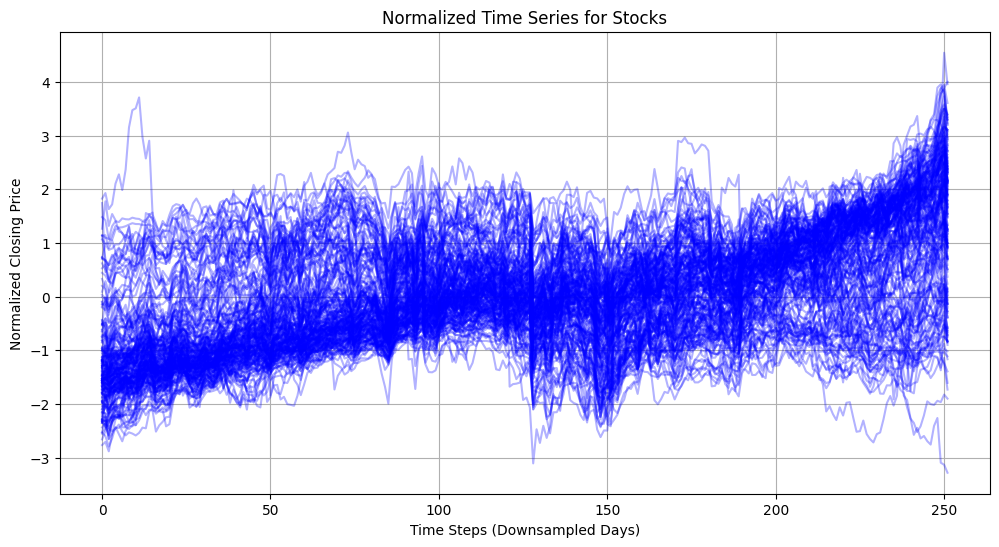

In [1]:
# Required imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
try:
    import tslearn
except ImportError:
    !pip install tslearn
from sklearn.metrics import silhouette_score, davies_bouldin_score
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
import kagglehub
import os
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import DBSCAN
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import cdist_dtw
import kagglehub
import os
from sklearn.metrics import pairwise_distances
from sklearn.cluster import OPTICS

# Download and load S&P 500 dataset
path = kagglehub.dataset_download("camnugent/sandp500")
print("Path to dataset files:", path)

# Load the combined CSV file
csv_file = os.path.join(path, "all_stocks_5yr.csv")
if not os.path.isfile(csv_file):
    raise FileNotFoundError(f"CSV file not found: {csv_file}")

data = pd.read_csv(csv_file)

# Parse dates
data['date'] = pd.to_datetime(data['date'])

# Pivot to get one time series per stock
pivoted = data.pivot(index='date', columns='Name', values='close')

# Drop stocks with missing values
pivoted.dropna(axis=1, inplace=True)

# Optionally limit the number of stocks for speed
if pivoted.shape[1] > 200:
    pivoted = pivoted.iloc[:, :200]

# Transpose to get each stock as a time series
time_series_data = pivoted.T.values

# Normalize each stock's time series
scaler = StandardScaler()
normalized_data = np.array([scaler.fit_transform(stock.reshape(-1, 1)).flatten() for stock in time_series_data])

# Optional downsampling (e.g., every 5th day)
normalized_data = normalized_data[:, ::5]

# Convert to tslearn format
data_tslearn = to_time_series_dataset(normalized_data)

# Plot the cluster centers
plt.figure(figsize=(12, 6))
for series in normalized_data:
    plt.plot(series, color = 'blue', alpha=0.3)  # Use alpha for transparency
plt.title("Normalized Time Series for Stocks")
plt.xlabel("Time Steps (Downsampled Days)")
plt.ylabel("Normalized Closing Price")
plt.grid(True)
plt.show()


In [2]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [ ]:
from scipy.fft import fft

# Apply FFT and keep first N frequency components
N_freq = 15
fft_features = np.array([np.abs(fft(ts))[:N_freq] for ts in normalized_data])
print(fft(normalized_data[0])[:])

# Normalize FFT features
scaler_fft = StandardScaler()
fft_scaled = scaler_fft.fit_transform(fft_features)

# Convert to tslearn format
fft_tslearn = to_time_series_dataset(fft_scaled)

# Compute DTW distance matrix
dtw_matrix = cdist_dtw(fft_tslearn)


In [3]:
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler

# Step 1: Apply FFT
fft_complex = np.array([fft(ts)[:N_freq] for ts in normalized_data])  # N_freq = 15

# Step 2: Extract magnitude and phase
magnitude = np.abs(fft_complex)
phase = np.angle(fft_complex)

# Step 3: Convert polar to Cartesian coordinates
x_coords = magnitude * np.cos(phase)
y_coords = magnitude * np.sin(phase)

# Step 4: Combine x and y into final Cartesian FFT features
fft_cartesian = np.concatenate([x_coords, y_coords], axis=1)  # shape = [n_series, 2*N_freq]
print(fft_cartesian)
# Step 5: Scale the features
scaler = StandardScaler()
polar_scaled = scaler.fit_transform(fft_cartesian)

# Step 6: Convert to time series dataset format for tslearn
polar_ts = to_time_series_dataset(polar_scaled.reshape(polar_scaled.shape[0], -1, 1))


[[-4.47685190e-01  1.15536601e+02 -3.91945351e+01 ...  1.20471025e+01
   1.82329110e+00  1.60150383e+01]
 [-9.63699217e-01 -6.21272409e+01 -2.44054727e+00 ...  6.98635490e+00
   1.33595301e+01  1.32938521e+01]
 [ 1.89280911e-01 -1.46704584e+02 -3.36972888e+01 ... -1.21856534e+00
   1.69978749e+00  1.63615227e+01]
 ...
 [-8.20515291e-01 -4.47193891e+00 -4.27254291e+01 ...  1.43239687e+01
   3.51439179e+00  5.29176241e+00]
 [-1.57772504e-02  3.16156689e+01 -1.09894921e+02 ...  1.02034786e+01
   8.58360147e-01  8.10396314e+00]
 [-1.14613387e+00  5.63103970e+00  3.48018002e+00 ...  1.27031707e+01
   6.41704173e+00  5.05897508e+00]]



Running KMeans with Euclidean KMeans...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


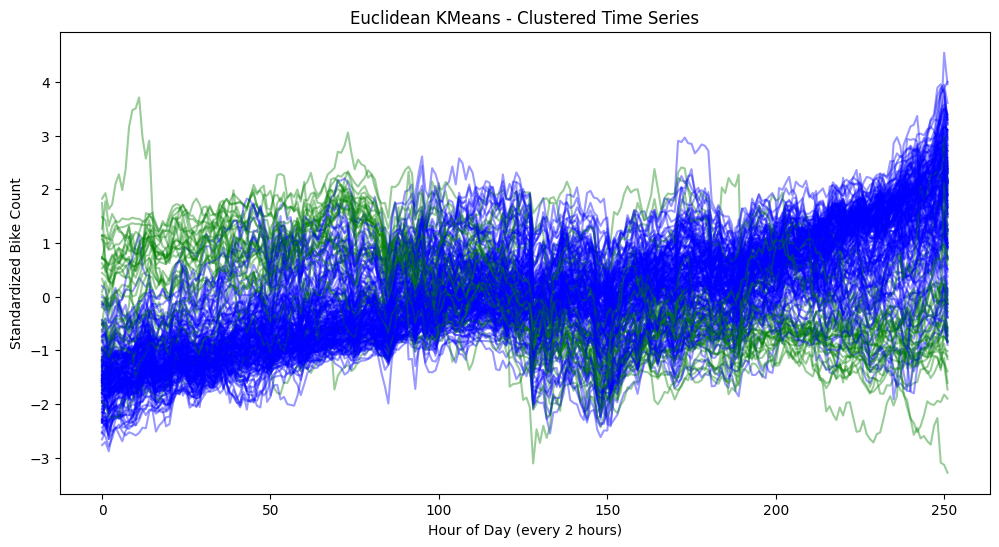

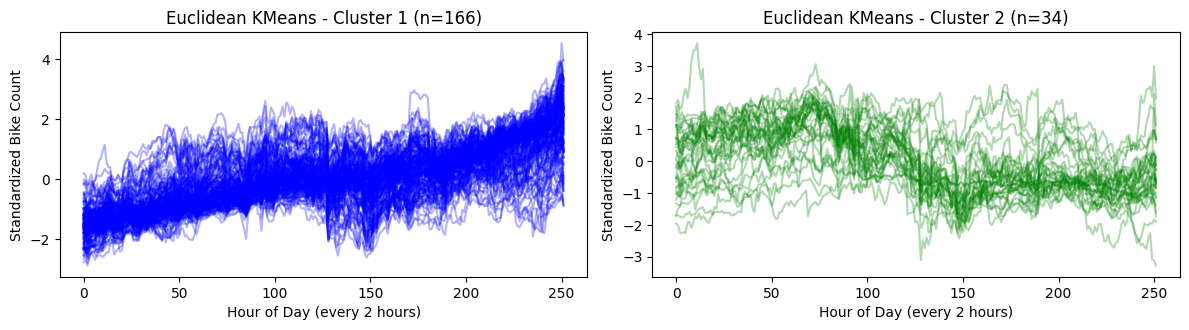

Silhouette Score: 0.3228522071645293 for K-Means with euclidean
Davies-Bouldin Score: 1.4049314084021525 for K-Means with euclidean

Running KMeans with DTW KMeans...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


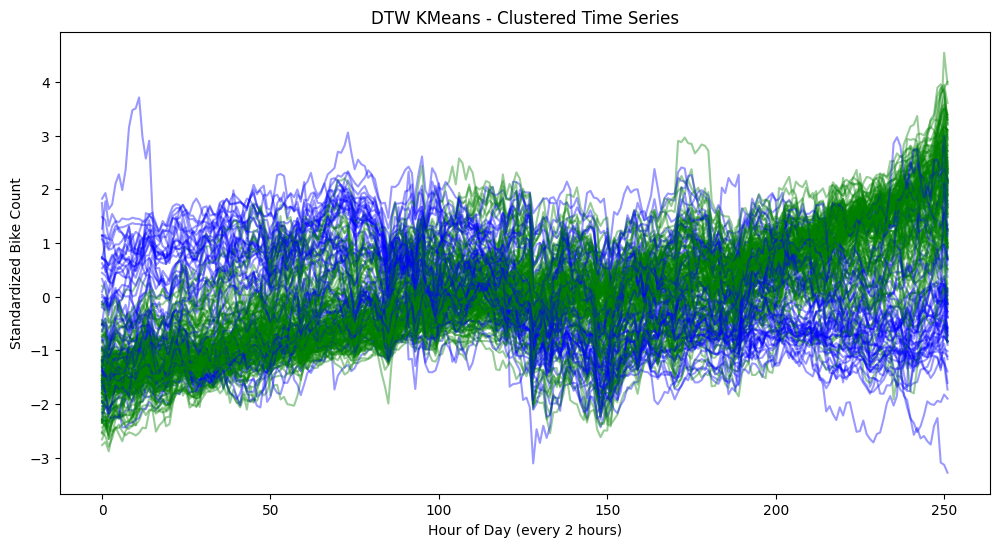

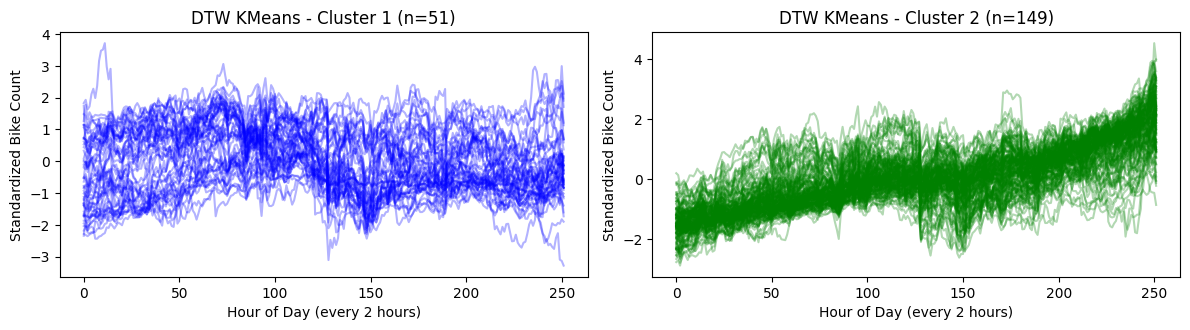

Silhouette Score: 0.2821383467361567 for K-Means with dtw
Davies-Bouldin Score: 1.8213084833555562 for K-Means with dtw


In [4]:
# Parameters
n_clusters = 2
colors = ["blue", "green", "red", "purple", "orange"]

# Clustering and plotting function
def run_kmeans(metric, title, metric_params=None):
    print(f"\nRunning KMeans with {title}...")
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric,
                              metric_params=metric_params,
                              random_state=42, n_init=10)
    labels = model.fit_predict(polar_ts)

    # Plot all series colored by cluster
    plt.figure(figsize=(12, 6))
    for i, series in enumerate(data_tslearn):
        plt.plot(series.ravel(), color=colors[labels[i]], alpha=0.4)
    plt.title(f"{title} - Clustered Time Series")
    plt.xlabel("Hour of Day (every 2 hours)")
    plt.ylabel("Standardized Bike Count")
    plt.show()

    # Plot cluster-wise breakdown
    plt.figure(figsize=(12, 6))
    for i in range(n_clusters):
        cluster_data = data_tslearn[labels == i]
        plt.subplot(2, 2, i + 1)
        for series in cluster_data:
            plt.plot(series.ravel(), color=colors[i], alpha=0.3)
        plt.title(f"{title} - Cluster {i+1} (n={len(cluster_data)})")
        plt.xlabel("Hour of Day (every 2 hours)")
        plt.ylabel("Standardized Bike Count")
    plt.tight_layout()
    plt.show()

    # Plot cluster means
    # plt.figure(figsize=(10, 6))
    # for i in range(n_clusters):
    #     mean_pattern = data_tslearn[labels == i].mean(axis=0)
    #     plt.plot(mean_pattern.ravel(), label=f"Cluster {i+1}", color=colors[i])
    # plt.title(f"{title} - Average Pattern per Cluster")
    # plt.xlabel("Hour of Day (every 2 hours)")
    # plt.ylabel("Standardized Bike Count")
    # plt.legend()
    # plt.show()

    # Print mean per cluster
    cluster_means = [np.mean(data_tslearn[labels == i]) for i in range(n_clusters)]
    # print(f"{title} - Average standardized rentals per cluster:")
    # for i, m in enumerate(cluster_means):
    #     print(f"  Cluster {i+1}: {m:.2f}")

    silhoutte_score = silhouette_score(polar_scaled, labels)
    print(f"Silhouette Score: {silhoutte_score} for K-Means with {metric}")
    db_score = davies_bouldin_score(polar_scaled, labels)
    print(f"Davies-Bouldin Score: {db_score} for K-Means with {metric}")

# === Run all three clustering methods ===
run_kmeans(metric="euclidean", title="Euclidean KMeans")

run_kmeans(metric="dtw", title="DTW KMeans")

# run_kmeans(metric="softdtw", title="Soft-DTW KMeans", metric_params={"gamma": 0.01})


<ipython-input-5-41f3337581d9>:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_euclidean = linkage(euclidean_dist, method='ward')


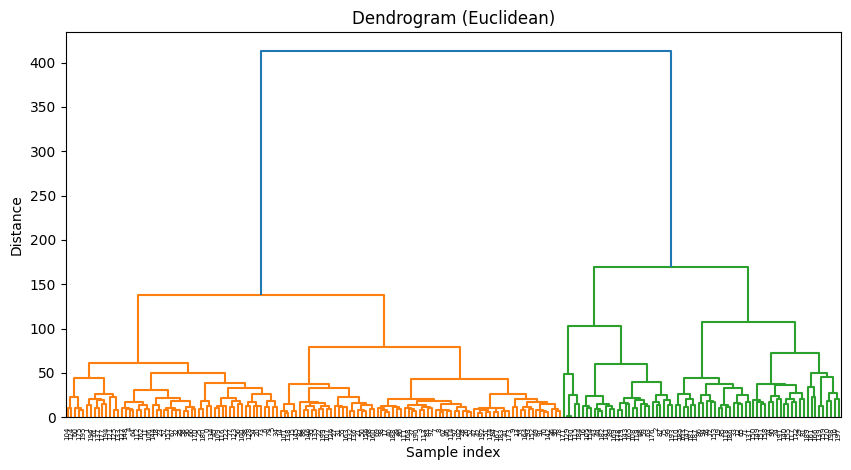

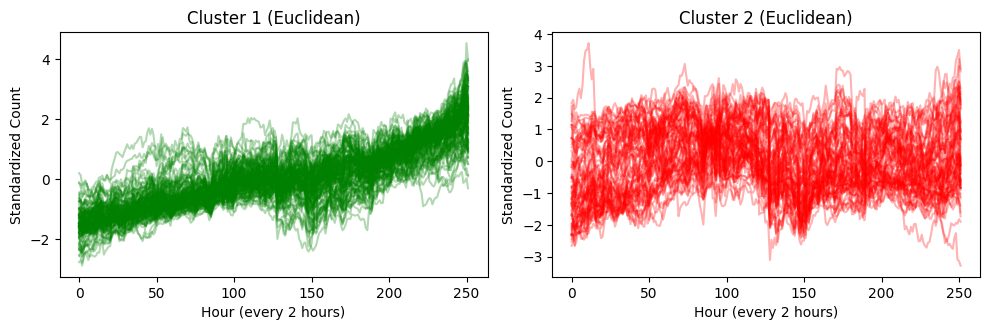

Silhouette Score: 0.23976275232228234 for Hierarchical with Euclidean
Davies-Bouldin Score: 2.181368132362596 for Hierarchical with Euclidean


In [5]:
# Compute Euclidean distance matrix on 2D feature array
euclidean_dist = pairwise_distances(polar_scaled, metric='euclidean')

# Linkage for hierarchical clustering
Z_euclidean = linkage(euclidean_dist, method='ward')

# Dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z_euclidean)
plt.title("Dendrogram (Euclidean)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

# Assign cluster labels
n_clusters = 2
labels_euclidean = fcluster(Z_euclidean, n_clusters, criterion='maxclust')

# Plot clusters (on original time series)
colors = ["blue", "green", "red", "orange", "purple", "black"]
plt.figure(figsize=(10, 3 * n_clusters))
for i in range(1, n_clusters + 1):
    plt.subplot(n_clusters, 2, i)
    for ts in normalized_data[labels_euclidean == i]:
        plt.plot(ts, color=colors[i % len(colors)], alpha=0.3)
    plt.title(f"Cluster {i} (Euclidean)")
    plt.xlabel("Hour (every 2 hours)")
    plt.ylabel("Standardized Count")
plt.tight_layout()
plt.show()

silhoutte_score = silhouette_score(polar_scaled, labels_euclidean)
print(f"Silhouette Score: {silhoutte_score} for Hierarchical with Euclidean")
db_score = davies_bouldin_score(polar_scaled, labels_euclidean)
print(f"Davies-Bouldin Score: {db_score} for Hierarchical with Euclidean")

<ipython-input-11-5d2c2354e099>:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_dtw = linkage(dtw_dist, method='average')


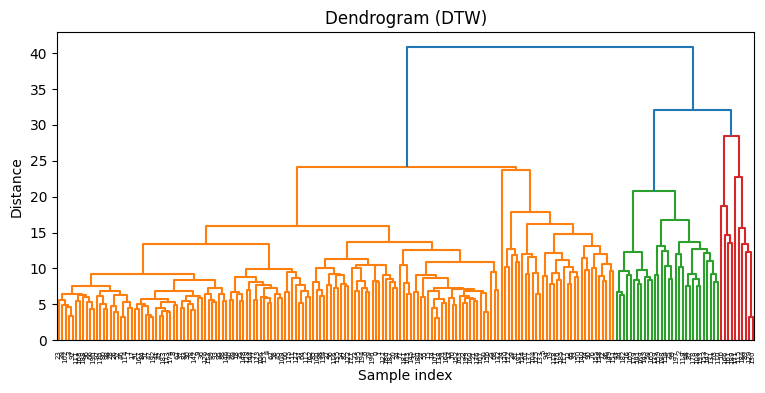

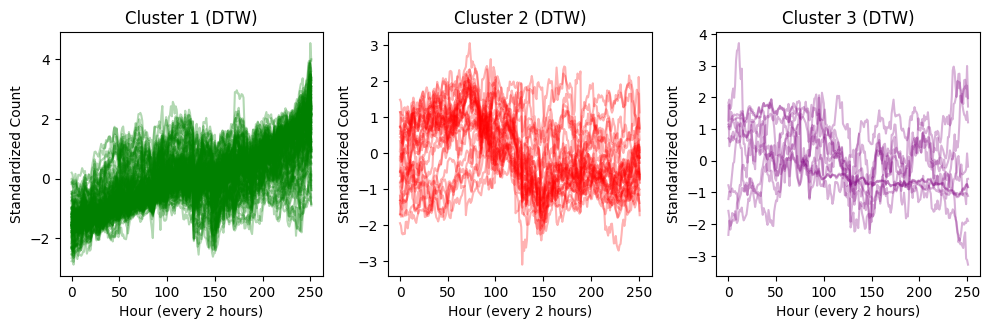

Silhouette Score: 0.27213710003492636 for Hierarchical with DTW
Davies-Bouldin Score: 4.420628906015575 for Hierarchical with DTW


In [11]:
# Compute DTW distance matrix
dtw_dist = cdist_dtw(polar_ts)

# Linkage (average is common for precomputed distances)
Z_dtw = linkage(dtw_dist, method='average')

# Plot dendrogram
plt.figure(figsize=(9, 4))
dendrogram(Z_dtw)
plt.title("Dendrogram (DTW)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

# Assign cluster labels
n_clusters_dtw = 3
labels_dtw = fcluster(Z_dtw, n_clusters_dtw, criterion='maxclust')

# Plot each cluster
plt.figure(figsize=(10, 3 * n_clusters_dtw))
for i in range(1, n_clusters_dtw + 1):
    plt.subplot(n_clusters_dtw, 3, i)
    for ts in normalized_data[labels_dtw == i]:
        plt.plot(ts, color=colors[i % len(colors)], alpha=0.3)
    plt.title(f"Cluster {i} (DTW)")
    plt.xlabel("Hour (every 2 hours)")
    plt.ylabel("Standardized Count")
plt.tight_layout()
plt.show()

silhoutte_score = silhouette_score(polar_scaled, labels_dtw)
print(f"Silhouette Score: {silhoutte_score} for Hierarchical with DTW")
db_score = davies_bouldin_score(polar_scaled, labels_dtw)
print(f"Davies-Bouldin Score: {db_score} for Hierarchical with DTW")

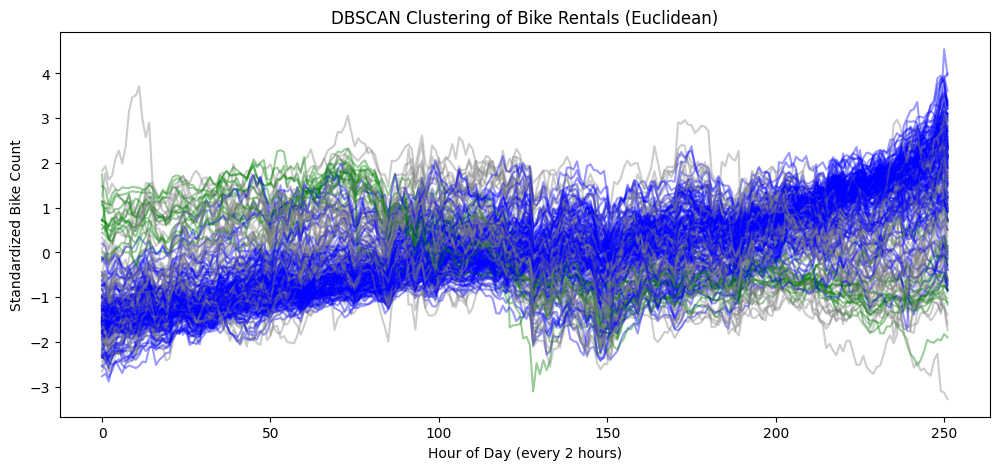

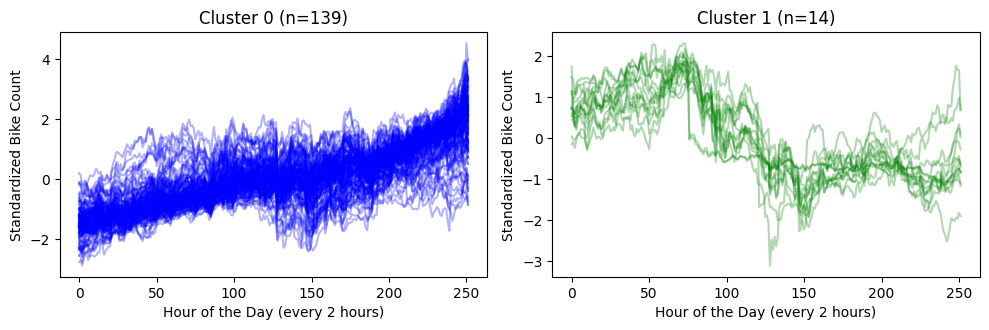

Silhouette Score: 0.23910278601959675 for DBSCAN with Euclidean
Davies-Bouldin Score: 2.603676729998553 for DBSCAN with Euclidean
DBSCAN (Euclidean) Cluster Sizes (label - count):
  Cluster -1: 47 time series
  Cluster 0: 139 time series
  Cluster 1: 14 time series


In [7]:
# Compute Euclidean distance matrix
euclidean_dist_matrix = pairwise_distances(polar_scaled, metric='euclidean')

# Apply DBSCAN clustering with Euclidean distance
db_euclidean = DBSCAN(eps=5, min_samples=5, metric='precomputed')
labels_euclidean = db_euclidean.fit_predict(euclidean_dist_matrix)

# Define plot colors
colors = ["blue", "green", "red", "purple", "orange", "black"]
unique_labels_euclidean = np.unique(labels_euclidean)

# Plot all series colored by cluster
plt.figure(figsize=(12, 5))
for i, series in enumerate(normalized_data):
    label = labels_euclidean[i]
    color = "gray" if label == -1 else colors[label % len(colors)]
    plt.plot(series, color=color, alpha=0.4)
plt.title("DBSCAN Clustering of Bike Rentals (Euclidean)")
plt.xlabel("Hour of Day (every 2 hours)")
plt.ylabel("Standardized Bike Count")
plt.show()

# Plot each cluster separately
n_clusters = len([l for l in unique_labels_euclidean if l != -1])
plt.figure(figsize=(10, 3 * n_clusters))
plot_idx = 1
for label in unique_labels_euclidean:
    if label == -1:
        continue
    cluster_data = normalized_data[labels_euclidean == label]
    plt.subplot(n_clusters, 2, plot_idx)
    for series in cluster_data:
        plt.plot(series.ravel(), color=colors[label % len(colors)], alpha=0.3)
    plt.title(f"Cluster {label} (n={len(cluster_data)})")
    plt.xlabel("Hour of the Day (every 2 hours)")
    plt.ylabel("Standardized Bike Count")
    plot_idx += 1
plt.tight_layout()
plt.show()

silhoutte_score = silhouette_score(polar_scaled, labels_euclidean)
print(f"Silhouette Score: {silhoutte_score} for DBSCAN with Euclidean")
db_score = davies_bouldin_score(polar_scaled, labels_euclidean)
print(f"Davies-Bouldin Score: {db_score} for DBSCAN with Euclidean")

# Summary
print("DBSCAN (Euclidean) Cluster Sizes (label - count):")
for label in unique_labels_euclidean:
    print(f"  Cluster {label}: {(labels_euclidean == label).sum()} time series")

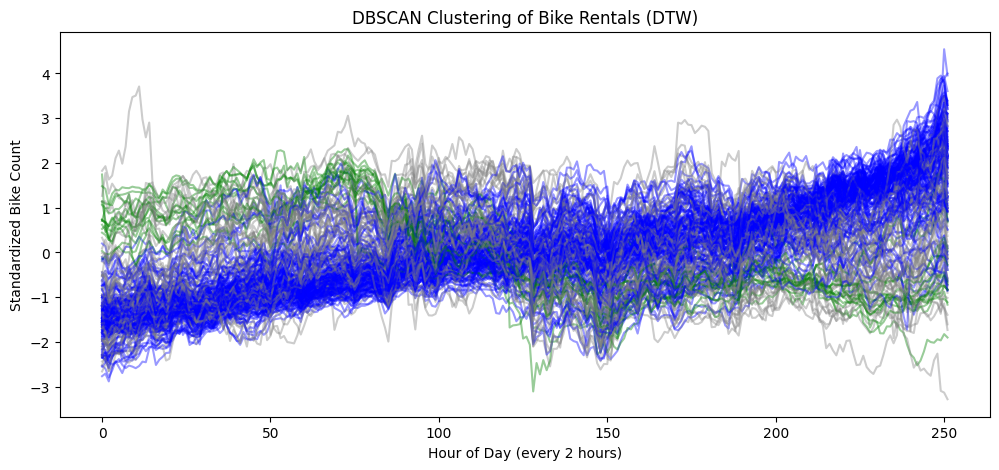

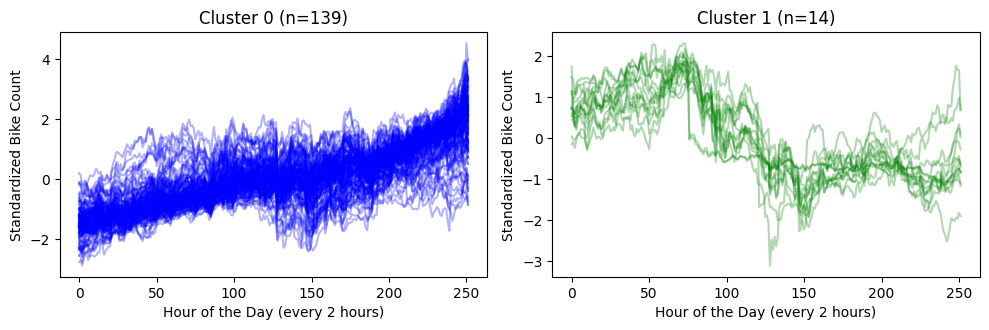

Silhouette Score: 0.1242092700977183 for DBSCAN with DTW
Davies-Bouldin Score: 6.72963533938243 for DBSCAN with DTW


In [8]:
# Apply DBSCAN clustering
eps = 2
min_samples = 5
db_model = DBSCAN(metric="precomputed", eps=eps, min_samples=min_samples)
cluster_labels = db_model.fit_predict(dtw_matrix)

# Plot time series by cluster
unique_clusters = np.unique(cluster_labels)
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']


# Plot all series colored by cluster
plt.figure(figsize=(12, 5))
for i, series in enumerate(normalized_data):
    label = labels_euclidean[i]
    color = "gray" if label == -1 else colors[label % len(colors)]
    plt.plot(series, color=color, alpha=0.4)
plt.title("DBSCAN Clustering of Bike Rentals (DTW)")
plt.xlabel("Hour of Day (every 2 hours)")
plt.ylabel("Standardized Bike Count")
plt.show()

# Plot each cluster separately
n_clusters = len([l for l in unique_labels_euclidean if l != -1])
plt.figure(figsize=(10, 3 * n_clusters))
plot_idx = 1
for label in unique_labels_euclidean:
    if label == -1:
        continue
    cluster_data = normalized_data[labels_euclidean == label]
    plt.subplot(n_clusters, 2, plot_idx)
    for series in cluster_data:
        plt.plot(series.ravel(), color=colors[label % len(colors)], alpha=0.3)
    plt.title(f"Cluster {label} (n={len(cluster_data)})")
    plt.xlabel("Hour of the Day (every 2 hours)")
    plt.ylabel("Standardized Bike Count")
    plot_idx += 1
plt.tight_layout()
plt.show()

silhoutte_score = silhouette_score(polar_scaled, cluster_labels)
print(f"Silhouette Score: {silhoutte_score} for DBSCAN with DTW")
db_score = davies_bouldin_score(polar_scaled, cluster_labels)
print(f"Davies-Bouldin Score: {db_score} for DBSCAN with DTW")

# print("Cluster assignments:", cluster_labels)


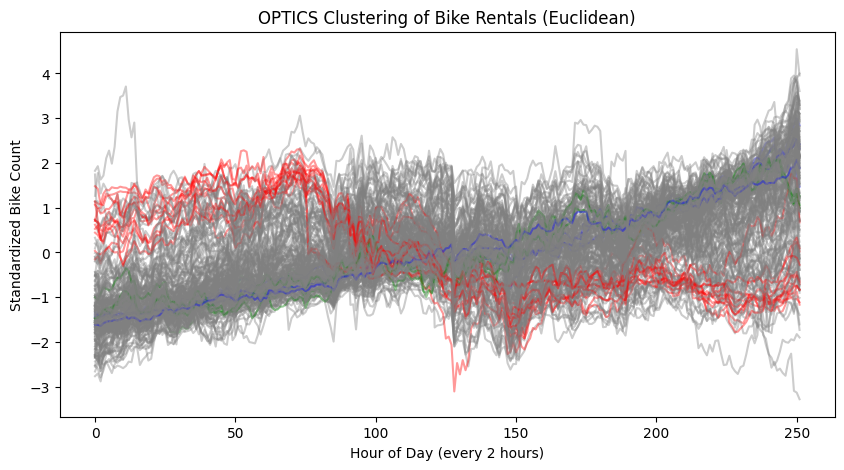

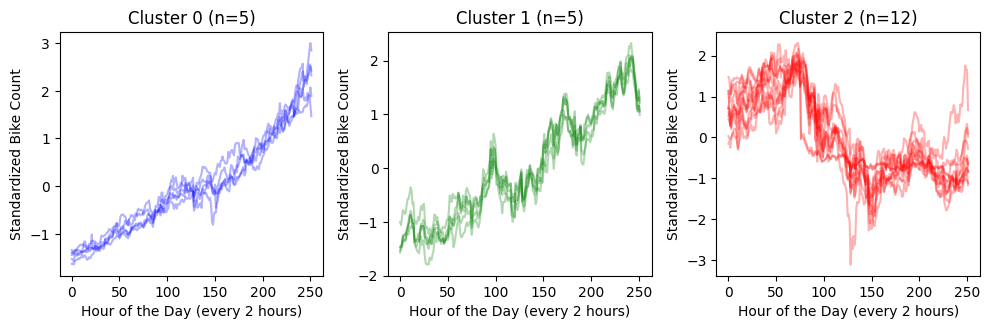

Silhouette Score: -0.2294417227101861 for OPTICS with Euclidean
Davies-Bouldin Score: 2.2805410604878005 for OPTICS with Euclidean
OPTICS (Euclidean) Cluster Sizes:
  Cluster -1: 178 time series
  Cluster 0: 5 time series
  Cluster 1: 5 time series
  Cluster 2: 12 time series


In [9]:
# Euclidean Distance Matrix
euclidean_dist_matrix = pairwise_distances(polar_scaled, metric='euclidean')

# OPTICS Clustering
optics_euclidean = OPTICS(metric='precomputed', min_samples=5, xi=0.09)
labels_optics_euclidean = optics_euclidean.fit_predict(euclidean_dist_matrix)

# Plotting Results
colors = ["blue", "green", "red", "purple", "orange", "black"]
unique_labels = np.unique(labels_optics_euclidean)

# Plot all series colored by cluster
plt.figure(figsize=(10, 5))
for i, series in enumerate(normalized_data):
    label = labels_optics_euclidean[i]
    color = "gray" if label == -1 else colors[label % len(colors)]
    plt.plot(series, color=color, alpha=0.4)
plt.title("OPTICS Clustering of Bike Rentals (Euclidean)")
plt.xlabel("Hour of Day (every 2 hours)")
plt.ylabel("Standardized Bike Count")
plt.show()

# Plot each cluster separately
n_clusters = len([l for l in unique_labels if l != -1])
plt.figure(figsize=(10, 3 * n_clusters))
plot_idx = 1
for label in unique_labels:
    if label == -1:
        continue
    cluster_data = normalized_data[labels_optics_euclidean == label]
    plt.subplot(n_clusters, 3, plot_idx)
    for series in cluster_data:
        plt.plot(series.ravel(), color=colors[label % len(colors)], alpha=0.3)
    plt.title(f"Cluster {label} (n={len(cluster_data)})")
    plt.xlabel("Hour of the Day (every 2 hours)")
    plt.ylabel("Standardized Bike Count")
    plot_idx += 1
plt.tight_layout()
plt.show()

silhoutte_score = silhouette_score(polar_scaled, labels_optics_euclidean)
print(f"Silhouette Score: {silhoutte_score} for OPTICS with Euclidean")
db_score = davies_bouldin_score(polar_scaled, labels_optics_euclidean)
print(f"Davies-Bouldin Score: {db_score} for OPTICS with Euclidean")

# Summary
print("OPTICS (Euclidean) Cluster Sizes:")
for label in unique_labels:
    print(f"  Cluster {label}: {(labels_optics_euclidean == label).sum()} time series")


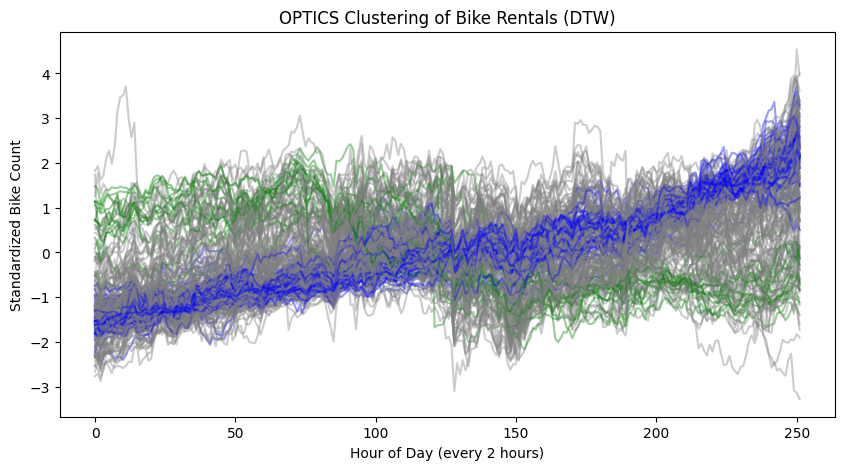

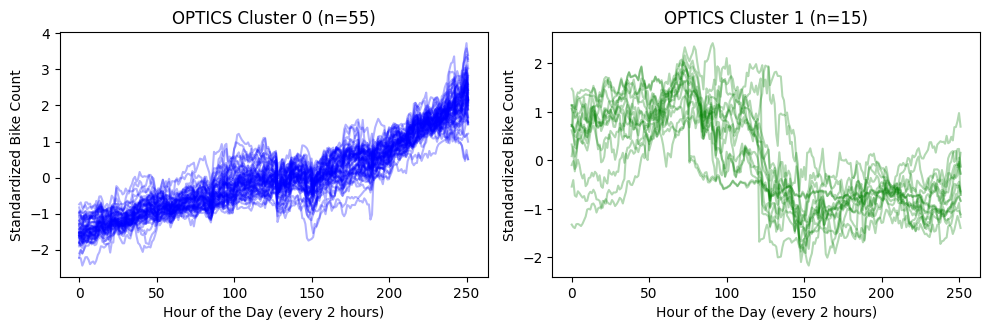

Silhouette Score: -0.01046386806509246 for OPTICS with DTW
Davies-Bouldin Score: 3.0723135644284216 for OPTICS with DTW


In [10]:
# Compute DTW distance matrix
dtw_dist_matrix = cdist_dtw(polar_ts)

# OPTICS with DTW
optics_dtw = OPTICS(min_samples=10, metric='precomputed', cluster_method='xi', xi=0.01)
labels_optics_dtw = optics_dtw.fit_predict(dtw_dist_matrix)

# Unique labels
unique_labels_optics_dtw = np.unique(labels_optics_dtw)

# Plot all series colored by cluster
plt.figure(figsize=(10, 5))
for i, series in enumerate(normalized_data):
    label = labels_optics_dtw[i]
    color = "gray" if label == -1 else colors[label % len(colors)]
    plt.plot(series, color=color, alpha=0.4)
plt.title("OPTICS Clustering of Bike Rentals (DTW)")
plt.xlabel("Hour of Day (every 2 hours)")
plt.ylabel("Standardized Bike Count")
plt.show()

# Plot each cluster separately
n_clusters = len([l for l in unique_labels_optics_dtw if l != -1])
plt.figure(figsize=(10, 3 * n_clusters))
plot_idx = 1
for label in unique_labels_optics_dtw:
    if label == -1:
        continue
    cluster_data = normalized_data[labels_optics_dtw == label]
    plt.subplot(n_clusters, 2, plot_idx)
    for series in cluster_data:
        plt.plot(series.ravel(), color=colors[label % len(colors)], alpha=0.3)
    plt.title(f"OPTICS Cluster {label} (n={len(cluster_data)})")
    plt.xlabel("Hour of the Day (every 2 hours)")
    plt.ylabel("Standardized Bike Count")
    plot_idx += 1
plt.tight_layout()
plt.show()

silhoutte_score = silhouette_score(polar_scaled, labels_optics_dtw)
print(f"Silhouette Score: {silhoutte_score} for OPTICS with DTW")
db_score = davies_bouldin_score(polar_scaled, labels_optics_dtw)
print(f"Davies-Bouldin Score: {db_score} for OPTICS with DTW")